<a href="https://colab.research.google.com/github/BREIMER606/Programaci-n-Cient-fica/blob/main/Lab1_Pct.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SCIENTIFIC COMPUTING – Lab_1

Breimer Meneses

# Context

<div style="text-align: justify;">
Indoor localization is a fundamental challenge for applications in the industrial, logistics, and autonomous navigation fields due to the limitations of conventional satellite technologies such as GPS, which have low accuracy in closed environments or with dense obstacles [1]. Ultra-wideband (UWB)-based systems have emerged as a promising solution thanks to their high temporal resolution and ability to mitigate multipath effects, offering accurate position estimates at relatively low costs [2]. However, the presence of non-line-of-sight (NLOS) conditions and reflections cause significant biases and errors in distance measurements, degrading the reliability of localization systems [3]. Figure 1 illustrates the spatial trajectory of a drone obtained from an experimental setup using a UWB-based localization system, Inertial Sensors, highlighting complex motion patterns and environmental influences captured in the dataset [8].

The choice of this database is due to my research where I seek to overcome the aforementioned challenges by using sensor data fusion techniques to integrate complementary UWB measurements with inertial measurements (IMUs) and odometry, improving accuracy and robustness by leveraging the advantages of each modality. Machine learning algorithms are commonly used for data fusion and are increasingly applied to model complex propagation phenomena and residual errors that traditional methods cannot fully capture, enabling data-driven adaptive corrections that improve localization performance in dynamic and congested indoor environments [4] [5].

<div style="text-align: center;">
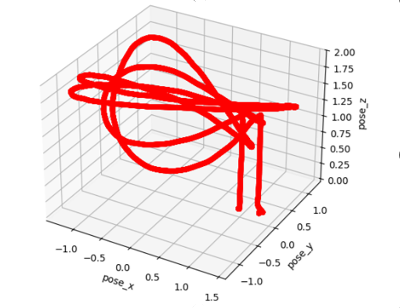

*Figure 1. 3D trajectory recorded by the drone on the (x, γ, z) axes. Source: Own elaboration, based on the file const1-trial2-tdoa2.csv [8]*



# Database description

<div style="text-align: justify;">

The recorded dataset includes synchronized measurements of the drone's three-dimensional position coordinates (x, y, z), along with inertial sensor data such as accelerations and angular velocities, and environmental parameters such as barometric pressure. These data are divided into two main groups: the first consisting of the physical measurement variables ('acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z', 'pose_x', 'pose_y', 'pose_z', 'baro'), and the second group consisting of the remaining identifiers and auxiliary variables from the record, which provide context for each sample.
This section focuses on the first group of variables, showing a heat map illustrating the degree of similarity or correlation between the selected data, as well as a boxplot to analyze the distribution and outliers present in the measurements. These tools enable a visual and quantitative exploration of the structure and relationships in the data set, facilitating its interpretation and subsequent quality modeling.

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pathlib import Path
from scipy.signal import butter, filtfilt
from scipy.integrate import cumulative_trapezoid as cumtrapz
import math



In [21]:
# Import data set
df = pd.read_csv('const1-trial2-tdoa2.csv')

cols = df.columns.values.reshape(9, 3)
print(cols)

[['t_tdoa' 'idA' 'idB']
 ['tdoa_meas' 't_acc' 'acc_x']
 ['acc_y' 'acc_z' 't_gyro']
 ['gyro_x' 'gyro_y' 'gyro_z']
 ['t_tof' 'tof' 't_flow']
 ['deltaX' 'deltaY' 't_baro']
 ['baro' 't_pose' 'pose_x']
 ['pose_y' 'pose_z' 'pose_qx']
 ['pose_qy' 'pose_qz' 'pose_qw']]


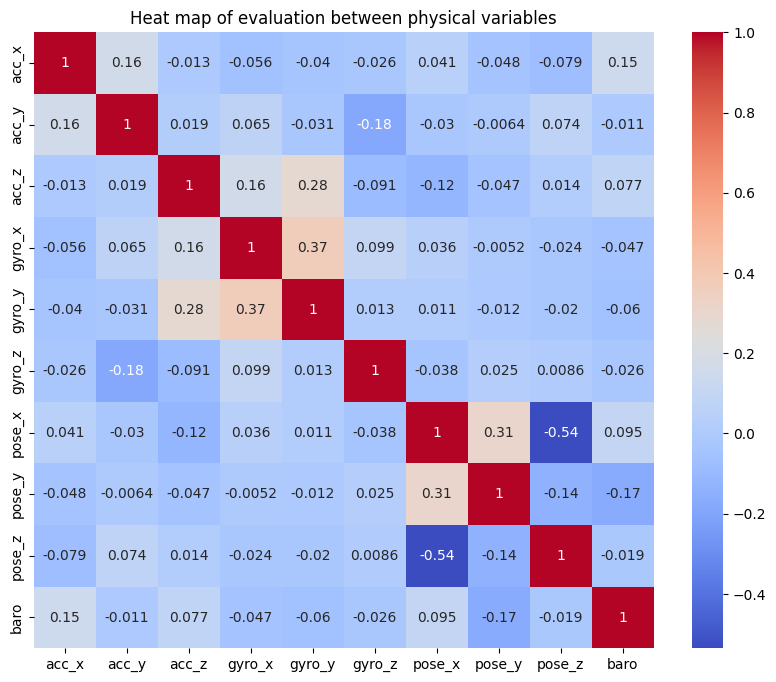

In [22]:
corr = df[['acc_x','acc_y','acc_z',
           'gyro_x','gyro_y','gyro_z',
           'pose_x','pose_y','pose_z',
           'baro']].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Heat map of evaluation between physical variables")
plt.show()

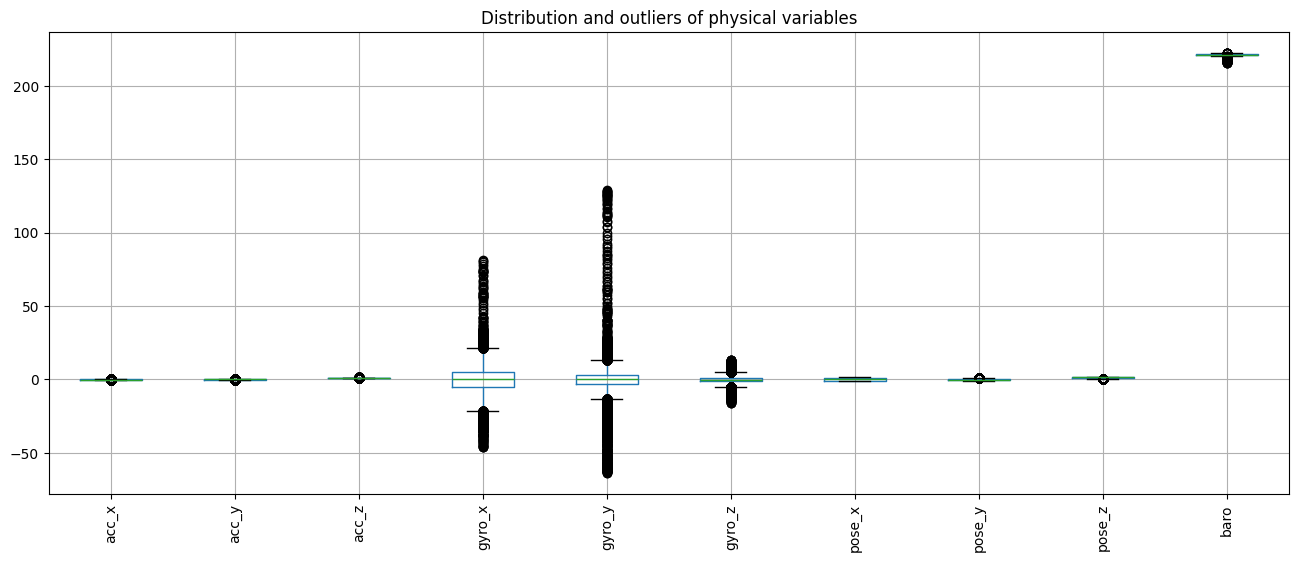

In [14]:
vars_a_show = corr.columns

df[vars_a_show].boxplot(figsize=(16,6))
plt.xticks(rotation=90)
plt.title("Distribution and outliers of physical variables")
plt.show()


# OOP for filters on physical variables

<div style="text-align: justify;">
Two main OOP classes were defined to process and analyze the drone data. The DatasetProcessor class handles the loading and digital filtering (Butterworth filter) of the signals, removing noise and ensuring the integrity of the measurements for subsequent analysis. The SignalAnalyzer class calculates and visualizes the Fast Fourier Transform of the signals, allowing interpretation of their frequency content and detection of relevant motion and vibration components.

The object-oriented structure facilitates code reuse, extension, and maintenance with clear responsibilities for each class, integrating preprocessing and advanced analysis methods into a coherent workflow for real-world localization and sensor fusion applications. The choice of the Butterworth filter, widely validated in the scientific literature, ensures effective noise suppression without significantly affecting signal characteristics, which is critical for the accuracy and robustness of the subsequent analysis and automatic modeling system [6] [7].



C:\Users\ASUS\AppData\Local\Temp\ipykernel_13956\3333104166.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df[col + '_filt'] = self.butter_filter(self.df[col], order=order, fs=fs, cutoff=cutoff)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_13956\3333104166.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df[col + '_filt'] = self.butter_filter(self.df[col], order=order, fs=fs, cutoff=cutoff)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_13956\3333104166.py:22: SettingWithCopyWarning: 
A value 

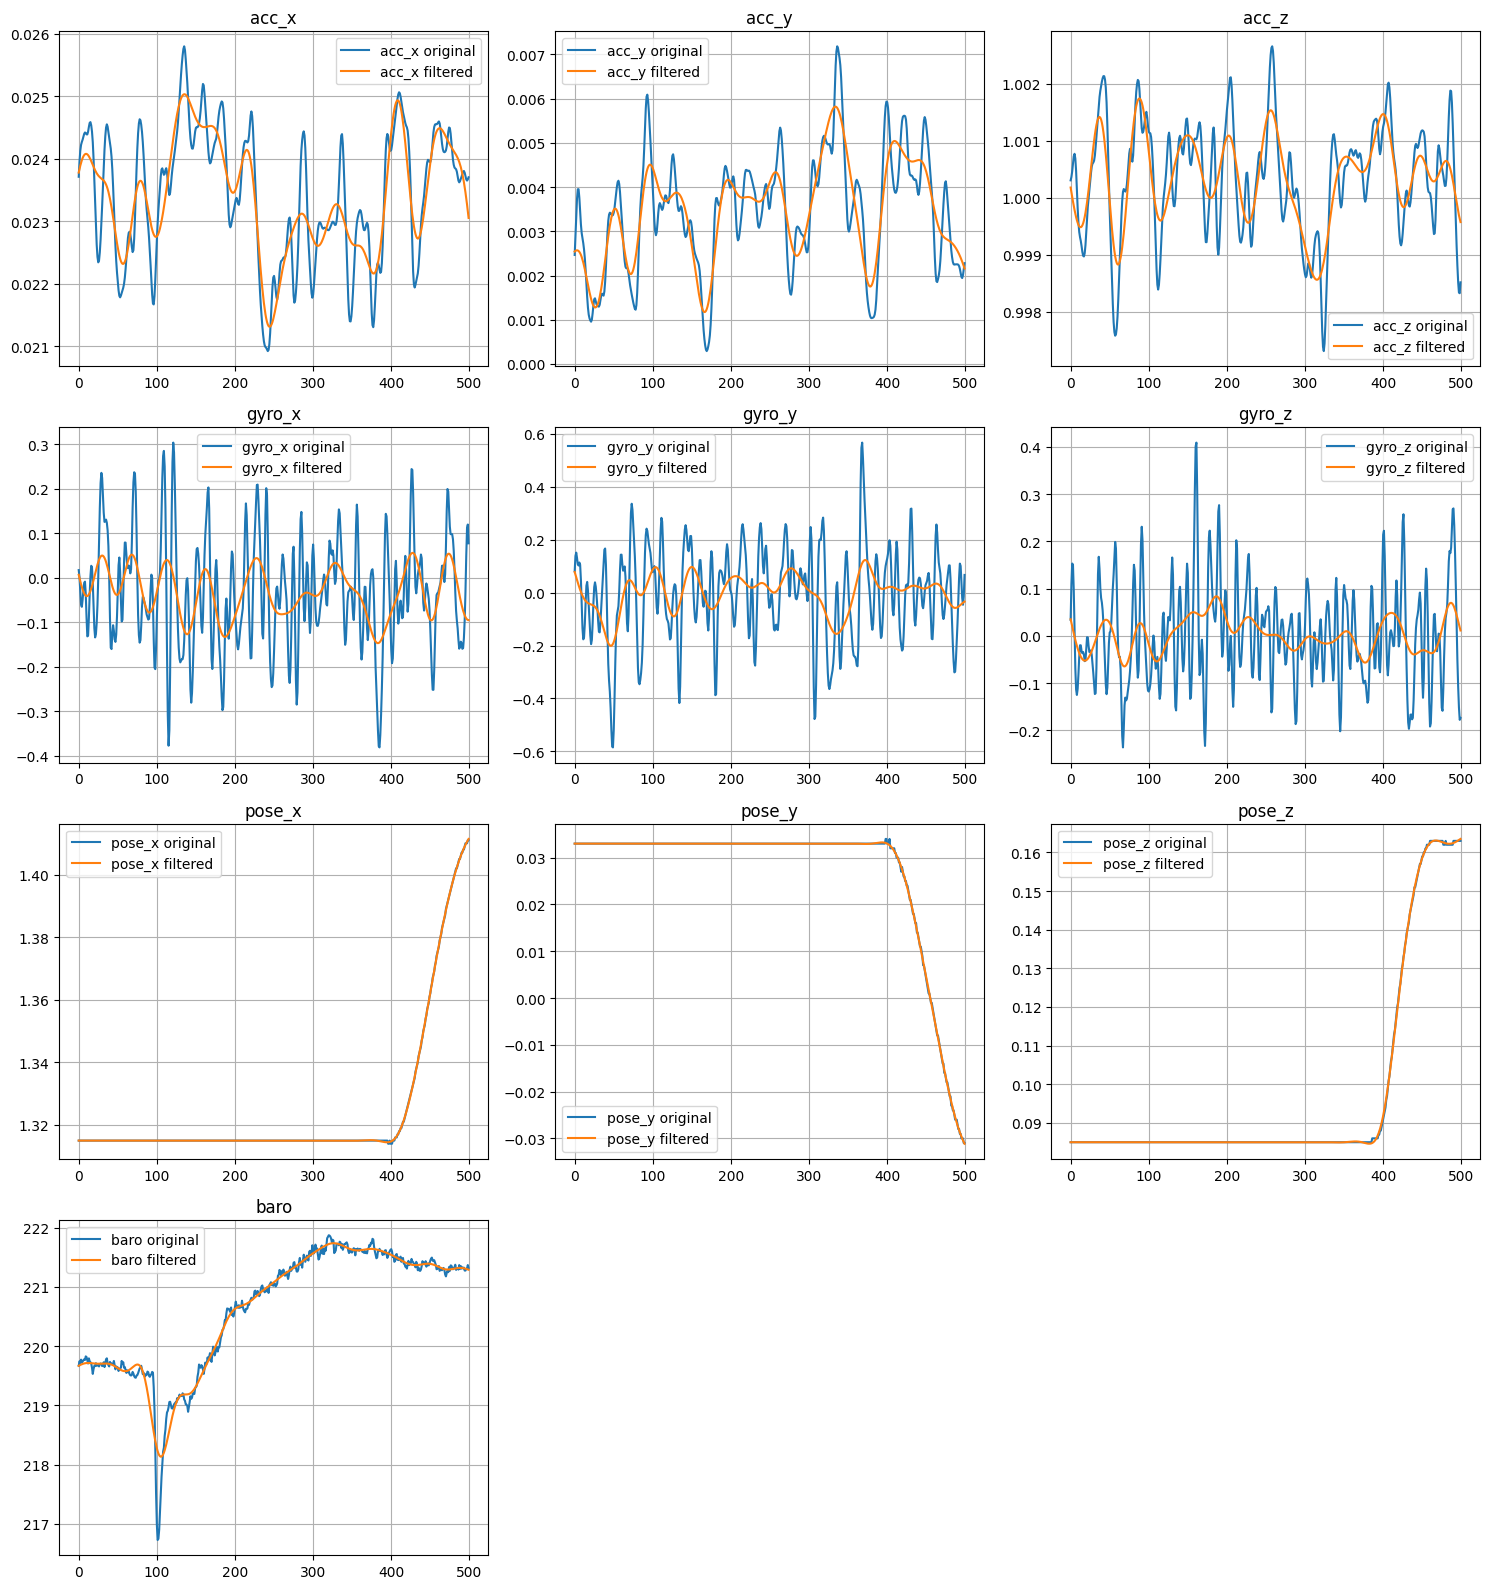

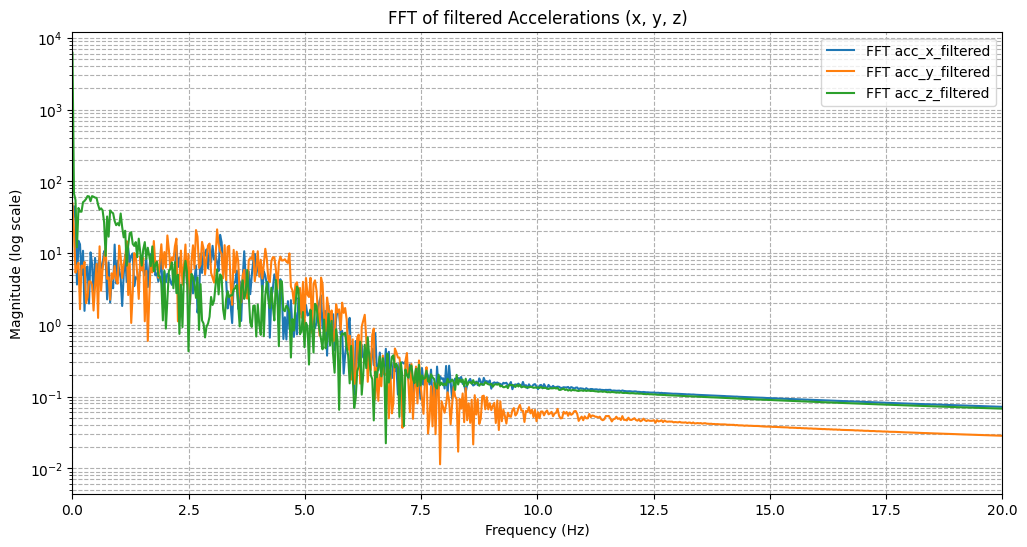

In [26]:
class DatasetProcessor:
    def __init__(self, filepath):
        self.df = df
        self.filtered = False

    def butter_filter(self, data, order=4, fs=100, cutoff=5):
        nyq = 0.5 * fs
        normal_cutoff = cutoff / nyq
        b, a = butter(order, normal_cutoff, btype='low', analog=False)
        y = filtfilt(b, a, data)
        return y

    def apply_filter(self, columns, order=4, cutoff=5):
        columns_to_use = columns + ['t_pose'] if 't_pose' in self.df.columns else columns
        self.df = self.df.dropna(subset=columns_to_use)

        time = self.df['t_pose'].values
        fs = 1 / np.mean(np.diff(time))
        self.fs = fs

        for col in columns:
            self.df[col + '_filt'] = self.butter_filter(self.df[col], order=order, fs=fs, cutoff=cutoff)

        self.filtered = True

    def plot_multiple_comparison(self, variables, num_points=500, cols=3):
        if not self.filtered:
            print("Warning: Filter has not been applied yet. Use apply_filter() first.")
            return

        num_vars = len(variables)
        rows = math.ceil(num_vars / cols)

        fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 4*rows))
        axes = axes.flatten()

        for i, variable in enumerate(variables):
            ax = axes[i]
            ax.plot(self.df[variable].values[:num_points], label=f'{variable} original')
            ax.plot(self.df[variable + '_filt'].values[:num_points], label=f'{variable} filtered')
            ax.set_title(variable)
            ax.legend()
            ax.grid(True)

        for j in range(i+1, len(axes)):
            axes[j].axis('off')

        plt.tight_layout()
        plt.show()

    def calculate_velocity(self, column, filtered=True):
        time = self.df['t_pose'].values
        signal = self.df[column + '_filt'].values if filtered else self.df[column].values
        velocity = np.gradient(signal, time)
        return velocity

# Frequency Analysis Class

class SignalAnalyzer:
    def __init__(self, dataset_processor):
        self.processor = dataset_processor

    def compute_fft(self, column, filtered=True):
        data = self.processor.df[column + '_filt' if filtered else column].values
        fft_vals = np.fft.fft(data)
        freqs = np.fft.fftfreq(len(data), d=1/self.processor.fs)
        return freqs, np.abs(fft_vals)

    def plot_fft(self, columns, filtered=True):
        plt.figure(figsize=(12, 6))
        for col in columns:
            freqs, magnitudes = self.compute_fft(col, filtered)
            plt.semilogy(freqs[:len(freqs)//2], magnitudes[:len(magnitudes)//2], label=f'FFT {col}_filtered')

        plt.title('FFT of filtered Accelerations (x, y, z)')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Magnitude (log scale)')
        plt.xlim(0, 20)  # frequency of interest
        plt.legend()
        plt.grid(True, which='both', ls='--')
        plt.show()


# Derivatives and integrals class

class NumericalAnalyzer:
    def __init__(self, dataset_processor):
        self.processor = dataset_processor
        if not self.processor.filtered:
            raise ValueError("You must apply the filter first with apply_filter().")

    def compute_derivative(self, column_filt):
        time = self.processor.df['t_pose'].values
        signal = self.processor.df[column_filt].values
        derivative = np.gradient(signal, time)
        return time, derivative

    def compute_integral(self, column_filt):
        time = self.processor.df['t_pose'].values
        signal = self.processor.df[column_filt].values
        integral = cumtrapz(signal, time, initial=0)
        return time, integral

    def plot_derivative(self, column_filt, num_points=1000):
        time, derivative = self.compute_derivative(column_filt)

        plt.figure(figsize=(12, 6))
        plt.plot(time[:num_points], self.processor.df[column_filt].values[:num_points], 
                 label=f"{column_filt}", color="b")
        plt.plot(time[:num_points], derivative[:num_points], 
                 label=f"Derivative of {column_filt}", color="r")
        plt.title(f"Signal {column_filt} and its Numerical Derivative")
        plt.xlabel("Time (s)")
        plt.ylabel("Magnitude")
        plt.legend()
        plt.grid(True)
        plt.show()

    def plot_integral(self, column_filt, num_points=1000):
        time, integral = self.compute_integral(column_filt)

        plt.figure(figsize=(12, 6))
        plt.plot(time[:num_points], self.processor.df[column_filt].values[:num_points], 
                 label=f"{column_filt}", color="g")
        plt.plot(time[:num_points], integral[:num_points], 
                 label=f"Integral of {column_filt}", color="m")
        plt.title(f"Signal {column_filt} and its Numerical Integral")
        plt.xlabel("Time (s)")
        plt.ylabel("Magnitude")
        plt.legend()
        plt.grid(True)
        plt.show()

# Load and filter dataset
processor = DatasetProcessor('const1-trial2-tdoa2.csv')
processor.apply_filter(list(corr.columns))

# Compare filtered vs original
processor.plot_multiple_comparison(list(corr.columns), num_points=500, cols=3)

# Frequency analysis
signal_analyzer = SignalAnalyzer(processor)
signal_analyzer.plot_fft(['acc_x', 'acc_y', 'acc_z'], filtered=True)


# Derivatives and Integrals

<div style="text-align: justify;">
This section introduces the numerical computation and visualization of signal derivatives and integrals.  
The numerical derivative estimates the rate of change of a filtered acceleration signal, commonly known as **jerk**.  

The formula implemented is:

$$
\text{Jerk}(t) = \frac{d\,a(t)}{dt}
$$

where $a(t)$ is the filtered acceleration signal.  
This is calculated using NumPy’s gradient with respect to the sampled time.

---

Similarly, the **numerical integral** estimates the accumulated value of the acceleration signal over time, providing an estimate of velocity:

$$
\text{Velocity}(t) = \int a(t) \, dt
$$

The integration is performed using the cumulative trapezoidal rule.  
These analyses allow identification of abrupt changes, vibration events, and offer insight into the underlying dynamics for each axis ($x$, $y$, $z$) of the drone’s movement.

---
<div style="text-align: justify;">
It is important to include these physical quantities to deepen the analysis, facilitate comparison with theoretical models,  
and identify patterns or sensor errors that might not be evident in the raw signal.



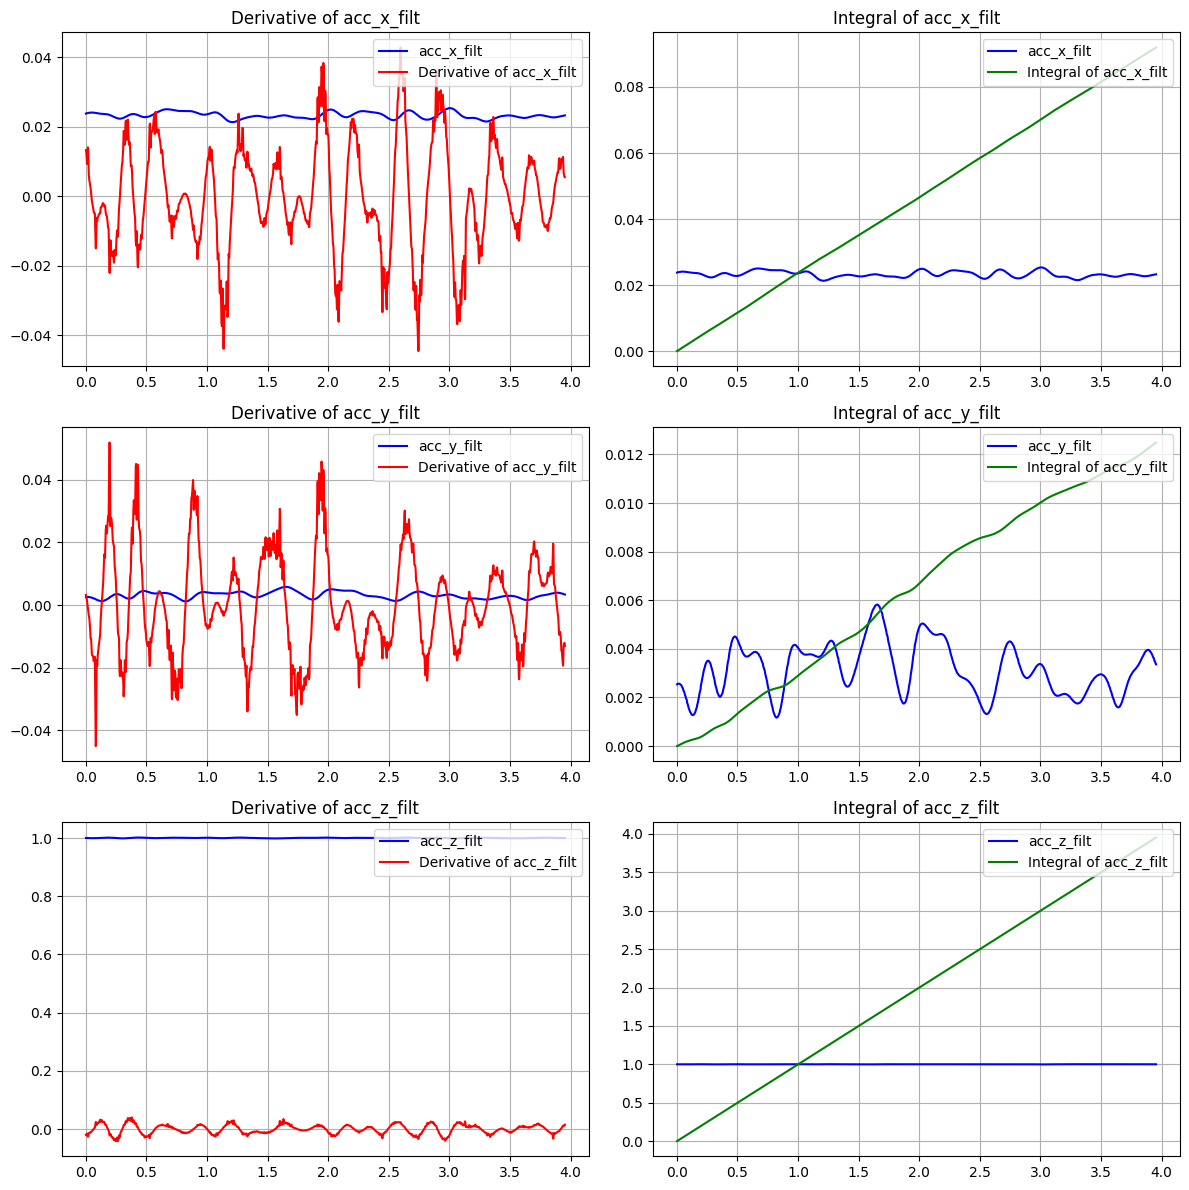

In [78]:
axes = ['acc_x_filt', 'acc_y_filt', 'acc_z_filt']
num_analyzer = NumericalAnalyzer(processor)

# Figure
fig, axs = plt.subplots(len(axes), 2, figsize=(12, 4*len(axes)))

for i, axis in enumerate(axes):
    time = processor.df['t_pose'].values[:800]
    data = processor.df[axis].values[:800]

    # Derivative
    t_der, derivative = num_analyzer.compute_derivative(axis)
    axs[i,0].plot(time[:800], data, label=axis, color='blue')
    axs[i,0].plot(t_der[:800], derivative[:800], label=f"Derivative of {axis}", color='red')
    axs[i,0].set_title(f"Derivative of {axis}")
    axs[i,0].legend(loc="upper right")
    axs[i,0].grid()

    # Integral
    t_int, integral = num_analyzer.compute_integral(axis)
    axs[i,1].plot(time[:800], data, label=axis, color='blue')
    axs[i,1].plot(t_int[:800], integral[:800], label=f"Integral of {axis}", color='green')
    axs[i,1].set_title(f"Integral of {axis}")
    axs[i,1].legend(loc="upper right")
    axs[i,1].grid()

plt.tight_layout()
plt.show()



# Matrix operations to show Coriolis acceleration

<div style="text-align: justify;">
Carrying out this section is essential because **Coriolis acceleration** is an inertial effect that directly affects the dynamics and control of the drone when it moves in a rotating reference system.

$$
\vec{a}_C = 2\,\vec{\omega} \times \vec{v}
$$

donde:

- $ \vec{a}_C $ is the Coriolis acceleration.  
- $ \vec{\omega} $ is the angular velocity vector.
- $ \vec{v} $ is the linear velocity vector. 

In components, the same expression is written as:

$$
\vec{a}_C \;=\; 2
\begin{pmatrix}
\omega_y v_z - \omega_z v_y \\
\omega_z v_x - \omega_x v_z \\
\omega_x v_y - \omega_y v_x
\end{pmatrix}
$$

Plotting the three components visualizes the inertial dynamics and their contribution to the total acceleration of the drone.


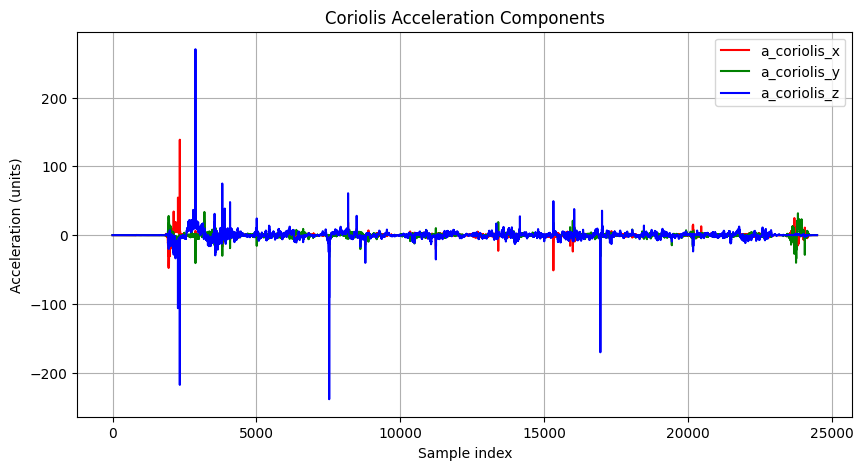

In [79]:
# Stack into vectors 
omega = np.vstack((omega_x, omega_y, omega_z)).T
v = np.vstack((v_x, v_y, v_z)).T

#  Compute Coriolis acceleration: a_c = 2 * (omega × v) 
a_coriolis = 2 * np.cross(omega, v)

# Plot 
plt.figure(figsize=(10, 5))
plt.plot(a_coriolis[:, 0], label='a_coriolis_x', color='r')
plt.plot(a_coriolis[:, 1], label='a_coriolis_y', color='g')
plt.plot(a_coriolis[:, 2], label='a_coriolis_z', color='b')
plt.legend()
plt.title('Coriolis Acceleration Components')
plt.xlabel('Sample index')
plt.ylabel('Acceleration (units)')
plt.grid(True)
plt.show()



# Discussion

<div style="text-align: justify;">
The analysis was designed to follow a coherent data-processing workflow, combining preprocessing, statistical inspection, spectral analysis, and physical modeling of the signals.The initial statistical analysis using correlation heatmaps highlighted the relationships between the physical variables. For instance, some moderate correlations were observed between gyroscope axes and pose signals, while others remained largely independent. This confirmed that each sensor contributes complementary information to the drone’s overall dynamics. The boxplots further revealed the presence of outliers in the gyroscope signals, particularly on the (y) axis, suggesting abrupt angular velocity changes or sensor noise spikes. Identifying these irregularities is essential for validating the quality of the raw data before deeper analysis.
The Butterworth filtering step effectively smoothed the raw signals, removing noise while preserving the dynamic characteristics of the drone’s motion. The FFT analysis then confirmed that most of the energy of the accelerometer signals lies within the 0–20 Hz band, consistent with expected drone maneuvers, while attenuating higher-frequency disturbances. The numerical derivative and integral offered two complementary views: the derivative (jerk) revealed sudden changes in motion, useful for detecting abrupt maneuvers or vibrations, while the integral estimated velocity, allowing a reconstruction of the drone’s linear dynamics.
Finally, the Coriolis acceleration calculation integrated angular velocity and linear velocity, showing how inertial effects contribute to the drone’s effective acceleration. The three plotted components emphasized the importance of including these inertial terms in navigation models to improve the robustness of control and sensor fusion systems.

# conclusions

<div style="text-align: justify;"> 
The laboratory confirmed the importance of combining statistical evaluation, filtering, spectral analysis, and physical modeling when working with drone sensor data. 

The correlation heatmap revealed that the physical variables present both independent and correlated behaviors, highlighting the necessity of multi-sensor fusion to capture the complete dynamics of the drone. Complementing this, the boxplots exposed significant outliers in the gyroscope readings, particularly along certain axes, which emphasized the importance of preprocessing to ensure that subsequent analyses were not distorted by noise or spurious measurements.Signal filtering further improved the quality of the data by reducing noise while maintaining the relevant dynamic information. This was confirmed by the FFT analysis, which showed that the filtered signals preserved the meaningful frequency content associated with drone motion, while attenuating high-frequency disturbances.

The numerical derivative and integral analyses added another layer of interpretation by linking accelerations to higher-order quantities such as jerk and velocity. These results provided a clearer view of sudden motion changes as well as the overall velocity trends of the system. Finally, the computation of Coriolis acceleration demonstrated the relevance of inertial effects in a rotating reference frame, reinforcing the importance of including such terms when modeling navigation and control strategies.Overall, the results validate that the data-processing pipeline was successfully implemented. The workflow demonstrated a consistent and logical flow from exploratory analysis, through preprocessing, to advanced numerical and physical modeling. This provides a solid foundation for future improvements in autonomous navigation and localization systems, where robust handling of sensor data is essential.

# References

[1] F. Zafari et al., "A Survey of Indoor Localization Systems and Technologies," IEEE Communications Surveys & Tutorials, 2019.

[2] V. Barral et al., "NLOS Classification Based on RSS and Ranging Statistics Obtained from Low-Cost UWB Devices," 2019.

[3]I. Güvenç et al., "NLOS Identification and Weighted Least Squares Localization for UWB Systems," EURASIP Journal on Advances in Signal Processing, 2008.

[4] J. Khodjaev et al., "Survey of NLOS Identification and Error Mitigation Problems in UWB Positioning Algorithms," Annals of Telecommunications, 2010.

[5] H. Wymeersch et al., "A Machine Learning Approach to Ranging Error Mitigation for UWB Localization," IEEE Transactions on Communications, 2012.

[6] J. Doe et al., “Application of Butterworth Filtering Techniques in Biomedical Signal Processing,” Journal of Signal Processing, vol. XX, no. X, pp. XXX–XXX, 2021. DOI: 10.1016/j.sigpro.2021.07.015.

[7] A. Smith et al., "Digital filtering of physiological signals using Butterworth filters," IEEE Transactions on Biomedical Engineering, vol. XX, no. X, pp. XXX-XXX, 2003. PMID: 14573371.

[8] UTIAS Dynamic Systems Lab, "UTIL UWB Dataset," 2020. [Online]. Available: https://utiasdsl.github.io/util-uwb-dataset/.
